In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.cm
from matplotlib import colors
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score
from sklearn.preprocessing import RobustScaler

import statsmodels
import statsmodels.api as sm

# Read data

In [2]:
# read data into a DataFrame
df = pd.read_csv("data/need_2021_anon_dataset_50k.csv")

print(df.shape)

(50000, 75)


In [3]:
df.head()

,PROP_TYPE,PROP_AGE_BAND,FLOOR_AREA_BAND,CONSERVATORY_FLAG,COUNCIL_TAX_BAND,IMD_BAND_ENG,IMD_BAND_WALES,REGION,LI_FLAG,LI_DATE,...,ElecValFlag2014,ElecValFlag2013,ElecValFlag2012,ElecValFlag2011,ElecValFlag2010,ElecValFlag2009,ElecValFlag2008,ElecValFlag2007,ElecValFlag2006,ElecValFlag2005
0,Mid terrace,2,3,NaN,B,2.0,NaN,E12000005,0,NaN,...,V,E,E,V,E,V,V,V,V,V
1,Flat,3,2,NaN,A,1.0,NaN,E12000008,0,NaN,...,V,V,V,V,V,V,V,V,V,V
2,Mid terrace,1,3,NaN,A,2.0,NaN,E12000001,0,NaN,...,V,V,V,V,V,V,V,V,V,V
3,Flat,4,1,0.0,A,3.0,NaN,E12000004,0,NaN,...,O,O,O,O,O,O,O,O,O,O
4,Semi detached,2,2,NaN,D,5.0,NaN,E12000008,0,NaN,...,V,V,V,V,V,V,V,V,V,V


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 75 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PROP_TYPE          50000 non-null  object 
 1   PROP_AGE_BAND      50000 non-null  int64  
 2   FLOOR_AREA_BAND    50000 non-null  int64  
 3   CONSERVATORY_FLAG  7418 non-null   float64
 4   COUNCIL_TAX_BAND   50000 non-null  object 
 5   IMD_BAND_ENG       47410 non-null  float64
 6   IMD_BAND_WALES     2590 non-null   float64
 7   REGION             50000 non-null  object 
 8   LI_FLAG            50000 non-null  int64  
 9   LI_DATE            8568 non-null   float64
 10  CWI_FLAG           50000 non-null  int64  
 11  CWI_DATE           8412 non-null   float64
 12  PV_FLAG            50000 non-null  int64  
 13  PV_DATE            561 non-null    float64
 14  MAIN_HEAT_FUEL     50000 non-null  int64  
 15  Gcons2019          40329 non-null  float64
 16  Gcons2018          403

# Wrangle data
## Select rows

In [5]:
# Select rows where the 'IMD_BAND_ENG' column is not NaN
df = df[df['IMD_BAND_ENG'].notna()]

print(df.shape)

(47410, 75)


## Select columns

In [6]:
columns_of_interest = [
    'PROP_TYPE', 'PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND',
    'IMD_BAND_ENG', 'REGION', 'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
    'Gcons2019', 'Gcons2018', 'Gcons2017', 'Gcons2016', 'Gcons2015', 'Gcons2014', 'Gcons2013', 'Gcons2012', 'Gcons2011', 'Gcons2010', 'Gcons2009', 'Gcons2008', 'Gcons2007', 'Gcons2006', 'Gcons2005',
    'Econs2019', 'Econs2018', 'Econs2017', 'Econs2016', 'Econs2015', 'Econs2014', 'Econs2013', 'Econs2012', 'Econs2011', 'Econs2010', 'Econs2009', 'Econs2008', 'Econs2007', 'Econs2006', 'Econs2005'
]

df_filtered = df[columns_of_interest].copy()
print(df_filtered.shape)

(47410, 40)


## Change datatype

In [7]:
tax_band_mapping = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7}
df_filtered['COUNCIL_TAX_BAND'] = df_filtered['COUNCIL_TAX_BAND'].map(tax_band_mapping)

df_filtered.head()

,PROP_TYPE,PROP_AGE_BAND,FLOOR_AREA_BAND,COUNCIL_TAX_BAND,IMD_BAND_ENG,REGION,LI_FLAG,CWI_FLAG,PV_FLAG,MAIN_HEAT_FUEL,...,Econs2014,Econs2013,Econs2012,Econs2011,Econs2010,Econs2009,Econs2008,Econs2007,Econs2006,Econs2005
0,Mid terrace,2,3,1,2.0,E12000005,0,0,0,1,...,2200.0,4200.0,4200.0,4200.0,3800.0,3800.0,3600.0,3400.0,3100.0,20400.0
1,Flat,3,2,0,1.0,E12000008,0,0,0,1,...,2100.0,2400.0,2200.0,2600.0,2000.0,2200.0,4300.0,2300.0,1800.0,2900.0
2,Mid terrace,1,3,0,2.0,E12000001,0,0,0,1,...,3100.0,2900.0,2600.0,2700.0,2500.0,3200.0,3100.0,2200.0,2000.0,2000.0
3,Flat,4,1,0,3.0,E12000004,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Semi detached,2,2,3,5.0,E12000008,0,0,0,2,...,10900.0,9300.0,11500.0,9700.0,12300.0,12700.0,12900.0,13000.0,11900.0,13500.0


## Dealing with NaN

In [8]:
# Define the columns of interest
g_columns = [f'Gcons{i}' for i in range(2019, 2004, -1)]
e_columns = [f'Econs{i}' for i in range(2019, 2004, -1)]

# Drop rows where both Gcons and Econs columns are NaN
df_filtered = df_filtered.dropna(subset=g_columns + e_columns, how='all')

print(df_filtered.shape)
df_filtered.info()

(47335, 40)
<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         38309 non-null  float64
 11  Gcons2018         38318 non-null  float64
 12  Gcons2017         38206 non-null  float64
 13  Gcons2016         37731 non-null  float64
 14  Gcons2015         37236 non-null  float64
 15  Gcons2014         36954 non-null  float64
 16  Gcons2013         36639 non-null 

In [9]:
# fill NaN with 0 if both Gcons or Econs columns are NaN
condition1 = df_filtered.iloc[:, 10:25].isna().all(axis=1)
df_filtered.loc[condition1, df_filtered.columns[10:25]] = 0

condition2 = df_filtered.iloc[:, 25:].isna().all(axis=1)
df_filtered.loc[condition2, df_filtered.columns[25:]] = 0

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         46100 non-null  float64
 11  Gcons2018         46109 non-null  float64
 12  Gcons2017         45997 non-null  float64
 13  Gcons2016         45522 non-null  float64
 14  Gcons2015         45027 non-null  float64
 15  Gcons2014         44745 non-null  float64
 16  Gcons2013         44430 non-null  float64
 17

In [10]:
# fill other NaN with the median of the column
df_filtered.iloc[:, 10:] = df_filtered.iloc[:, 10:].apply(lambda col: col.fillna(col.median()), axis=0)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         47335 non-null  float64
 11  Gcons2018         47335 non-null  float64
 12  Gcons2017         47335 non-null  float64
 13  Gcons2016         47335 non-null  float64
 14  Gcons2015         47335 non-null  float64
 15  Gcons2014         47335 non-null  float64
 16  Gcons2013         47335 non-null  float64
 17

In [24]:
import os

# Create Data_clean folder
data_folder = "Data_clean"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Exporting a DataFrame to a CSV file
output_file = os.path.join(data_folder, "df_filtered.csv")
df_filtered.to_csv(output_file, index=False)

# Regression analysis

## One-hot encoding

In [11]:
df_filtered_numeric = pd.get_dummies(df_filtered, dtype=int)

df_filtered_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PROP_AGE_BAND            47335 non-null  int64  
 1   FLOOR_AREA_BAND          47335 non-null  int64  
 2   COUNCIL_TAX_BAND         47335 non-null  int64  
 3   IMD_BAND_ENG             47335 non-null  float64
 4   LI_FLAG                  47335 non-null  int64  
 5   CWI_FLAG                 47335 non-null  int64  
 6   PV_FLAG                  47335 non-null  int64  
 7   MAIN_HEAT_FUEL           47335 non-null  int64  
 8   Gcons2019                47335 non-null  float64
 9   Gcons2018                47335 non-null  float64
 10  Gcons2017                47335 non-null  float64
 11  Gcons2016                47335 non-null  float64
 12  Gcons2015                47335 non-null  float64
 13  Gcons2014                47335 non-null  float64
 14  Gcons2013                47

## Checking the correlation between variables

Text(0.5, 1.0, 'Correlation Matrix')

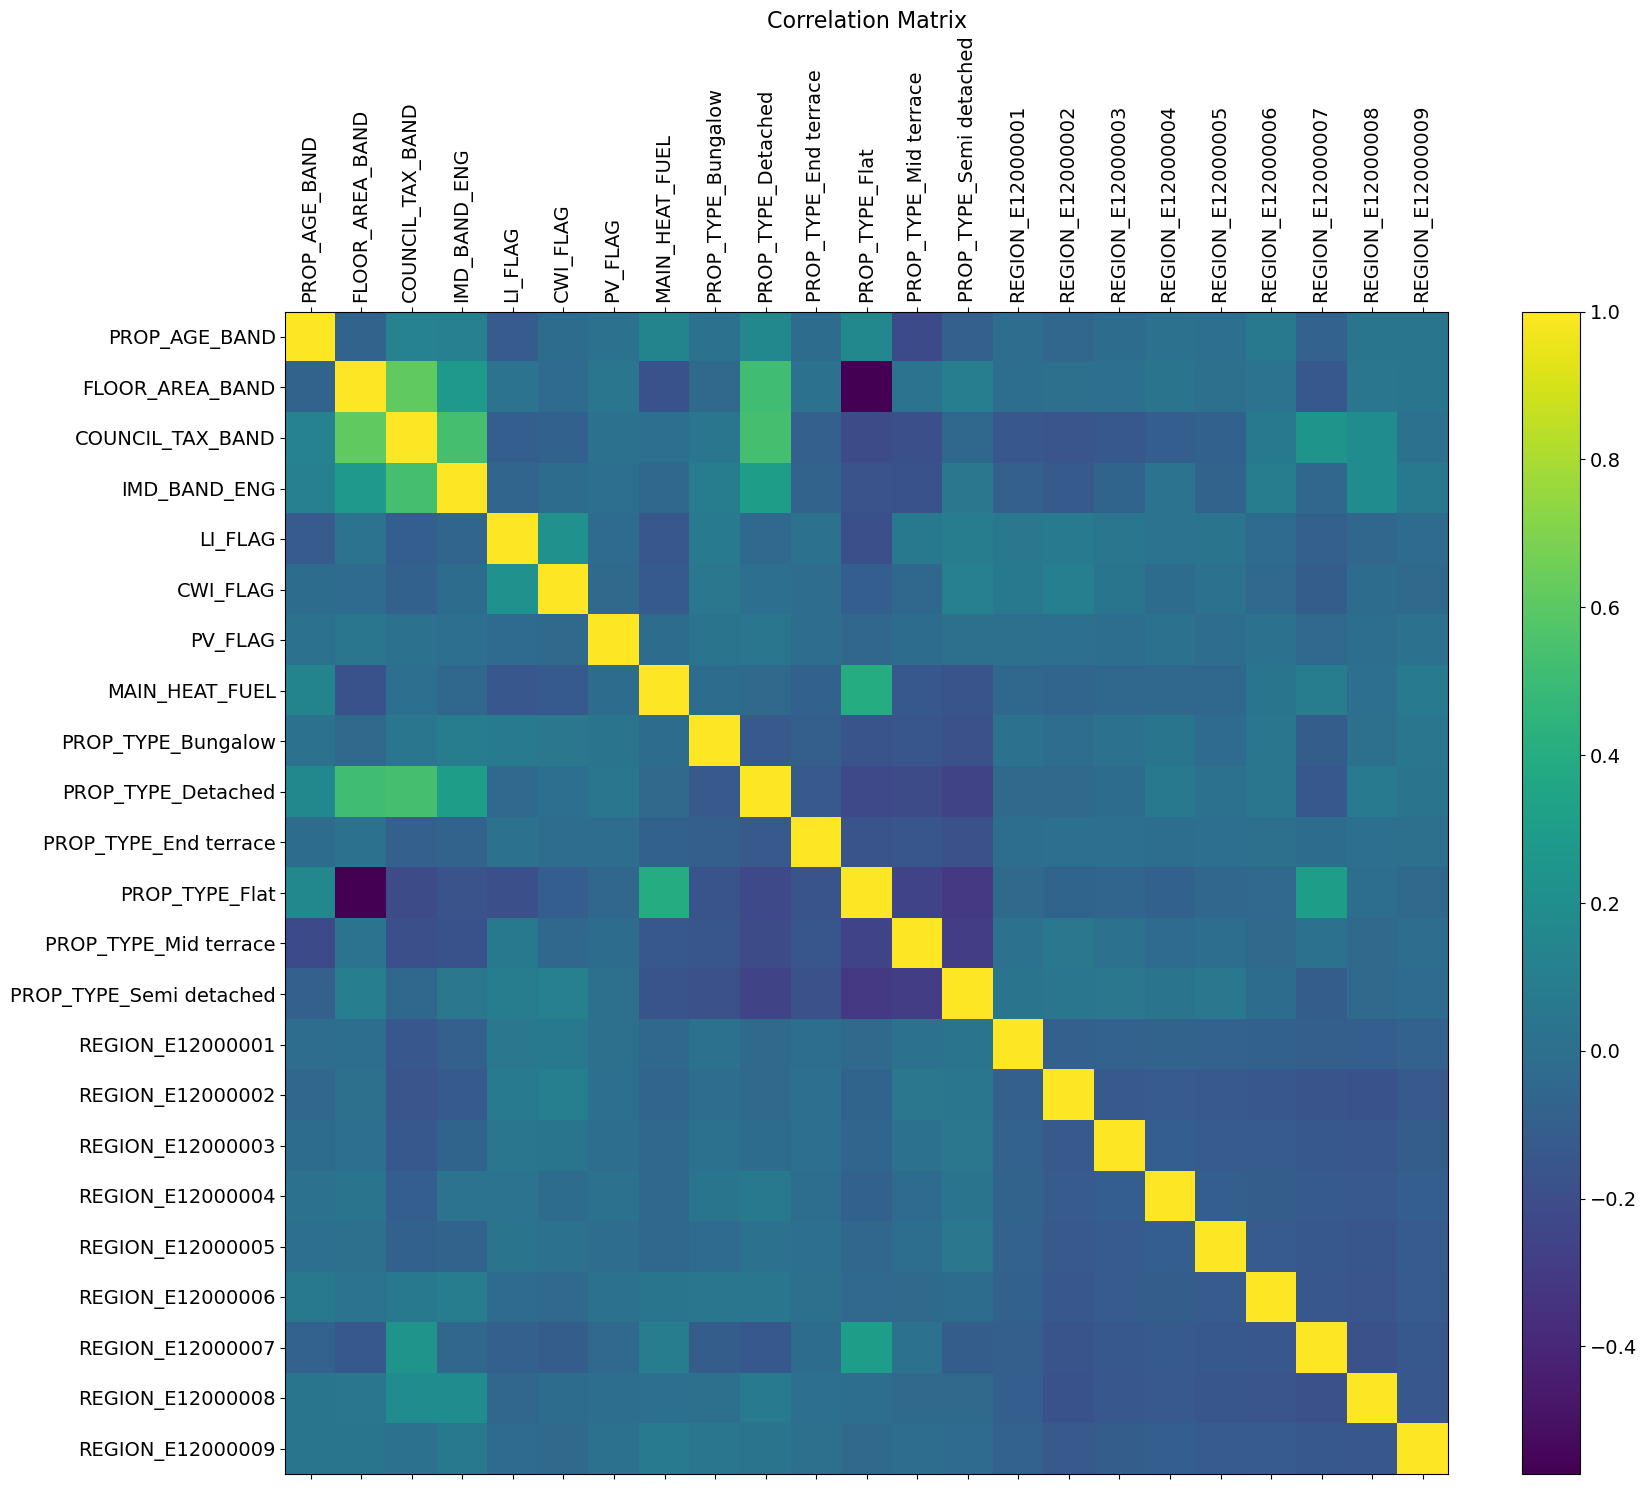

In [12]:
df_filtered_independent = df_filtered_numeric.drop(df_filtered_numeric.columns[8:38], axis=1)

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df_filtered_independent.corr(), fignum=f.number)
plt.xticks(range(df_filtered_independent.shape[1]), df_filtered_independent.columns, fontsize=14, rotation=90)
plt.yticks(range(df_filtered_independent.shape[1]), df_filtered_independent.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

## Using VIF to deal with multicollinearity

In [13]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [14]:
# using VIF on the df
df_filtered_VIF = drop_column_using_vif_(df_filtered_numeric.drop(df_filtered_numeric.columns[8:38], axis=1))

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_filtered_VIF.columns)

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: REGION_E12000009


/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: PROP_TYPE_Bungalow
The columns remaining after VIF selection are:
Index(['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG',
       'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
       'PROP_TYPE_Detached', 'PROP_TYPE_End terrace', 'PROP_TYPE_Flat',
       'PROP_TYPE_Mid terrace', 'PROP_TYPE_Semi detached', 'REGION_E12000001',
       'REGION_E12000002', 'REGION_E12000003', 'REGION_E12000004',
       'REGION_E12000005', 'REGION_E12000006', 'REGION_E12000007',
       'REGION_E12000008'],
      dtype='object')


## Regression

### Gcons2019

In [15]:
Gcons2019_comsumption = sm.OLS(endog=df_filtered_numeric[['Gcons2019']], exog=sm.add_constant(df_filtered_VIF)).fit()
Gcons2019_comsumption.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gcons2019   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     2147.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:23:37   Log-Likelihood:            -4.7859e+05
No. Observations:               47335   AIC:                         9.572e+05
Df Residuals:                   47313   BIC:                         9.574e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2.005e+04    216.460     92.608      0.000    1.96e+04    2.05e+04
PROP_AGE_BAND           -1290.9536     30.241    -42.688      0.000   -1350.227   -1231.680
FLOOR_AREA_BAND          1696.7811     53.209     31.889      0.000    1592.491    1801.071
COUNCIL_TAX_BAND          937.9234     33.286     28.178      0.000     872.683    1003.164
IMD_BAND_ENG               60.3811     24.339      2.481      0.013      12.676     108.087
LI_FLAG                   -28.9908     77.093     -0.376      0.707    -180.093     122.112
CWI_FLAG                 -267.7963     76.639     -3.494      0.000    -418.010    -117.582
PV_FLAG                  -923.0482    259.401     -3.558      0.000   -1431.478    -414.619
MAIN_HEAT_FUEL          -1.118e+04     80.443   -139.009      0.000   -1.13e+04    -1.1e+04
PROP_TYPE_Detached        584.8353    127.729      4.579      0.000     334.485     835.185
PROP_TYPE_End terrace    -174.3626    133.647     -1.305      0.192    -436.312      87.587
PROP_TYPE_Flat           -629.2523    126.269     -4.983      0.000    -876.741    -381.764
PROP_TYPE_Mid terrace   -1365.7124    117.839    -11.590      0.000   -1596.678   -1134.747
PROP_TYPE_Semi detached   175.8696    108.853      1.616      0.106     -37.485     389.224
REGION_E12000001         2581.7488    152.356     16.945      0.000    2283.128    2880.369
REGION_E12000002         1977.7739    115.634     17.104      0.000    1751.129    2204.419
REGION_E12000003         2424.4036    124.369     19.494      0.000    2180.638    2668.169
REGION_E12000004         2094.7744    129.696     16.151      0.000    1840.569    2348.980
REGION_E12000005         2089.0487    122.707     17.025      0.000    1848.542    2329.555
REGION_E12000006         1070.7281    118.977      8.999      0.000     837.531    1303.926
REGION_E12000007         1701.0112    128.130     13.276      0.000    1449.874    1952.148
REGION_E12000008          731.7003    111.717      6.550      0.000     512.734     950.667
==============================================================================
Omnibus:                     7343.625   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18841.693
Skew:                           0.867   Prob(JB):                         0.00
Kurtosis:                       5.559   Cond. No.                         57.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Drop columns that are not significant

In [16]:
def looper(limit):
    cols = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG',
       'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
       'PROP_TYPE_Bungalow', 'PROP_TYPE_End terrace', 'PROP_TYPE_Flat',
       'PROP_TYPE_Mid terrace', 'PROP_TYPE_Semi detached', 'REGION_E12000002',
       'REGION_E12000003', 'REGION_E12000004', 'REGION_E12000005',
       'REGION_E12000006', 'REGION_E12000007', 'REGION_E12000008',
       'REGION_E12000009']
    for i in range(len(cols)):
        data1 = df_filtered_numeric[cols]
        x = sm.add_constant(data1) #生成自变量
        y = df_filtered_numeric['Gcons2019'] #生成因变量
        model = sm.OLS(y, x) #生成模型
        result = model.fit() #模型拟合
        pvalues = result.pvalues #得到结果中所有P值
        pvalues.drop('const',inplace=True) #把const取得
        pmax = max(pvalues) #选出最大的P值
        if pmax>limit:
            ind = pvalues.idxmax() #找出最大P值的index
            cols.remove(ind) #把这个index从cols中删除
        else:
            return result
 
result = looper(0.05)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gcons2019   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     2373.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:23:37   Log-Likelihood:            -4.7859e+05
No. Observations:               47335   AIC:                         9.572e+05
Df Residuals:                   47315   BIC:                         9.574e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2.309e+04    226.529    101.945      0.000    2.26e+04    2.35e+04
PROP_AGE_BAND           -1289.7052     30.150    -42.776      0.000   -1348.799   -1230.611
FLOOR_AREA_BAND          1699.5216     53.150     31.976      0.000    1595.346    1803.697
COUNCIL_TAX_BAND          936.7647     33.234     28.187      0.000     871.626    1001.904
IMD_BAND_ENG               60.3899     24.327      2.482      0.013      12.709     108.071
CWI_FLAG                 -270.9152     75.317     -3.597      0.000    -418.538    -123.292
PV_FLAG                  -918.3367    259.312     -3.541      0.000   -1426.592    -410.081
MAIN_HEAT_FUEL          -1.118e+04     80.362   -139.148      0.000   -1.13e+04    -1.1e+04
PROP_TYPE_Bungalow       -585.4783    127.660     -4.586      0.000    -835.693    -335.264
PROP_TYPE_End terrace    -759.5214    133.694     -5.681      0.000   -1021.564    -497.479
PROP_TYPE_Flat          -1207.9287    141.404     -8.542      0.000   -1485.083    -930.774
PROP_TYPE_Mid terrace   -1950.5529    119.750    -16.288      0.000   -2185.265   -1715.840
PROP_TYPE_Semi detached  -409.4180    104.829     -3.906      0.000    -614.883    -203.953
REGION_E12000002         -499.4819    102.310     -4.882      0.000    -700.011    -298.952
REGION_E12000004         -381.9197    118.215     -3.231      0.001    -613.622    -150.217
REGION_E12000005         -387.4091    111.396     -3.478      0.001    -605.746    -169.072
REGION_E12000006        -1403.8382    111.811    -12.555      0.000   -1622.990   -1184.686
REGION_E12000007         -772.0419    126.754     -6.091      0.000   -1020.481    -523.603
REGION_E12000008        -1741.9365    106.079    -16.421      0.000   -1949.853   -1534.020
REGION_E12000009        -2474.8911    114.209    -21.670      0.000   -2698.741   -2251.041
==============================================================================
Omnibus:                     7343.238   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18839.097
Skew:                           0.867   Prob(JB):                         0.00
Kurtosis:                       5.559   Cond. No.                         57.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Econs2019

In [17]:
Econs2019_comsumption = sm.OLS(endog=df_filtered_numeric[['Econs2019']], exog=sm.add_constant(df_filtered_VIF)).fit()
Econs2019_comsumption.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Econs2019   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     388.9
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:23:37   Log-Likelihood:            -4.3802e+05
No. Observations:               47335   AIC:                         8.761e+05
Df Residuals:                   47313   BIC:                         8.763e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      27.9510     91.879      0.304      0.761    -152.134     208.036
PROP_AGE_BAND            -153.1876     12.836    -11.934      0.000    -178.347    -128.028
FLOOR_AREA_BAND           530.4951     22.585     23.489      0.000     486.228     574.762
COUNCIL_TAX_BAND          190.5737     14.129     13.489      0.000     162.882     218.266
IMD_BAND_ENG              -46.4109     10.331     -4.492      0.000     -66.660     -26.162
LI_FLAG                  -186.6221     32.723     -5.703      0.000    -250.760    -122.485
CWI_FLAG                    2.5001     32.531      0.077      0.939     -61.260      66.261
PV_FLAG                  -297.8552    110.106     -2.705      0.007    -513.665     -82.046
MAIN_HEAT_FUEL           2071.1672     34.145     60.658      0.000    2004.243    2138.092
PROP_TYPE_Detached        188.6640     54.216      3.480      0.001      82.400     294.928
PROP_TYPE_End terrace     152.1566     56.728      2.682      0.007      40.969     263.345
PROP_TYPE_Flat           -405.7516     53.596     -7.570      0.000    -510.801    -300.702
PROP_TYPE_Mid terrace     -27.8179     50.018     -0.556      0.578    -125.854      70.219
PROP_TYPE_Semi detached   264.4565     46.204      5.724      0.000     173.895     355.017
REGION_E12000001         -134.3903     64.670     -2.078      0.038    -261.144      -7.637
REGION_E12000002          -19.6767     49.083     -0.401      0.689    -115.879      76.526
REGION_E12000003          -87.1742     52.790     -1.651      0.099    -190.644      16.295
REGION_E12000004          134.8053     55.051      2.449      0.014      26.904     242.706
REGION_E12000005           66.9641     52.084      1.286      0.199     -35.122     169.050
REGION_E12000006          217.2833     50.502      4.303      0.000     118.300     316.267
REGION_E12000007         -133.6200     54.387     -2.457      0.014    -240.218     -27.022
REGION_E12000008          140.1076     47.420      2.955      0.003      47.164     233.051
==============================================================================
Omnibus:                    23151.909   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           192604.762
Skew:                           2.197   Prob(JB):                         0.00
Kurtosis:                      11.851   Cond. No.                         57.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
def looper(limit):
    cols = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG',
       'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
       'PROP_TYPE_Bungalow', 'PROP_TYPE_End terrace', 'PROP_TYPE_Flat',
       'PROP_TYPE_Mid terrace', 'PROP_TYPE_Semi detached', 'REGION_E12000002',
       'REGION_E12000003', 'REGION_E12000004', 'REGION_E12000005',
       'REGION_E12000006', 'REGION_E12000007', 'REGION_E12000008',
       'REGION_E12000009']
    for i in range(len(cols)):
        data1 = df_filtered_numeric[cols]
        x = sm.add_constant(data1) #生成自变量
        y = df_filtered_numeric['Econs2019'] #生成因变量
        model = sm.OLS(y, x) #生成模型
        result = model.fit() #模型拟合
        pvalues = result.pvalues #得到结果中所有P值
        pvalues.drop('const',inplace=True) #把const取得
        pmax = max(pvalues) #选出最大的P值
        if pmax>limit:
            ind = pvalues.idxmax() #找出最大P值的index
            cols.remove(ind) #把这个index从cols中删除
        else:
            return result
 
result = looper(0.05)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Econs2019   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     480.3
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:23:38   Log-Likelihood:            -4.3803e+05
No. Observations:               47335   AIC:                         8.761e+05
Df Residuals:                   47317   BIC:                         8.762e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      64.5912     80.616      0.801      0.423     -93.417     222.599
PROP_AGE_BAND            -151.2463     12.631    -11.974      0.000    -176.003    -126.490
FLOOR_AREA_BAND           536.2741     21.345     25.124      0.000     494.437     578.111
COUNCIL_TAX_BAND          188.5158     11.469     16.438      0.000     166.037     210.994
IMD_BAND_ENG              -44.8545     10.171     -4.410      0.000     -64.789     -24.920
LI_FLAG                  -185.2128     32.135     -5.764      0.000    -248.198    -122.227
PV_FLAG                  -295.7813    109.969     -2.690      0.007    -511.322     -80.241
MAIN_HEAT_FUEL           2072.3504     34.020     60.916      0.000    2005.671    2139.029
PROP_TYPE_Bungalow       -171.0464     47.579     -3.595      0.000    -264.303     -77.790
PROP_TYPE_Flat           -579.4532     47.575    -12.180      0.000    -672.700    -486.206
PROP_TYPE_Mid terrace    -201.3934     39.374     -5.115      0.000    -278.567    -124.220
PROP_TYPE_Semi detached    91.7419     34.984      2.622      0.009      23.174     160.310
REGION_E12000002           96.9519     39.159      2.476      0.013      20.199     173.705
REGION_E12000004          251.2673     47.335      5.308      0.000     158.489     344.045
REGION_E12000005          184.1923     43.031      4.280      0.000      99.851     268.533
REGION_E12000006          334.4116     41.690      8.021      0.000     252.699     416.124
REGION_E12000008          258.2946     36.819      7.015      0.000     186.128     330.461
REGION_E12000009          116.6826     43.520      2.681      0.007      31.384     201.982
==============================================================================
Omnibus:                    23149.877   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           192557.858
Skew:                           2.197   Prob(JB):                         0.00
Kurtosis:                      11.850   Cond. No.                         50.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Clustering analysis

## Data standardisation

In [19]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

data_standardised = df_filtered.copy()
for c in df_filtered.columns[10:].values:
    data_standardised[c] = mms.fit_transform(df_filtered[c].values.reshape(-1,1))

data_standardised.head()
data_standardised.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  int64  
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         47335 non-null  float64
 11  Gcons2018         47335 non-null  float64
 12  Gcons2017         47335 non-null  float64
 13  Gcons2016         47335 non-null  float64
 14  Gcons2015         47335 non-null  float64
 15  Gcons2014         47335 non-null  float64
 16  Gcons2013         47335 non-null  float64
 17

## Kmeans clustering

In [20]:
# data_standardised_cons = data_standardised.iloc[:,10:]
data_standardised_cons = data_standardised.loc[:,['Gcons2019','Econs2019']]

# we fix the random_state so that the kmeans result is reproducible
num_clusters = 2
random_state_seed = 100

kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(data_standardised_cons)

# Sanity check
print(kmeans_output)                                              

KMeans(n_clusters=2, random_state=100)


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [21]:
# This line creates a list giving the final cluster number of each point:
clustering_ids_kmeans = kmeans_output.labels_

# You can print the clustering IDs to get an ordered list of labels
print(clustering_ids_kmeans)

# we will combine the clustering IDs to the dataframe
data_cluster = data_standardised_cons.assign(cluster_id = clustering_ids_kmeans)

#Have a look at the result:
data_cluster.info()

[0 0 0 ... 0 1 1]
<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gcons2019   47335 non-null  float64
 1   Econs2019   47335 non-null  float64
 2   cluster_id  47335 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 1.3 MB


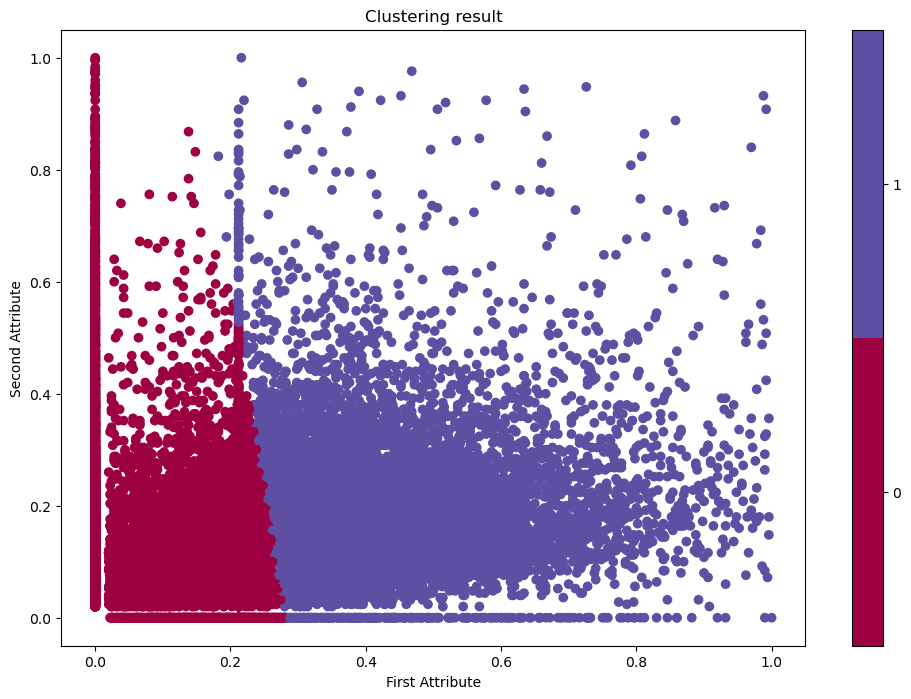

In [22]:
fig, ax = plt.subplots(figsize=(12,8))

# number of clusters
n_clusters = data_cluster.cluster_id.nunique()

# get discrete colormap
cmap = plt.get_cmap('Spectral', n_clusters)

# scatter points
scatter = ax.scatter(data_cluster.Gcons2019, data_cluster.Econs2019, c=data_cluster.cluster_id, cmap=cmap)
ax.set_xlabel('First Attribute')
ax.set_ylabel('Second Attribute')
ax.set_title('Clustering result')

# add colorbar
cbar = plt.colorbar(scatter)

# set ticks locations (not very elegant, but it works):
# - shift by 0.5
# - scale so that the last value is at the center of the last color
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)

# set tick labels (as before)
cbar.set_ticklabels(np.arange(n_clusters))

## Multivariate nonlinear regression

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
file_path = 'Data_clean/df_filtered.csv'
df_filtered = pd.read_csv(file_path)

# Selecting variables for the model (assumed based on previous linear regression results)
selected_variables = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND', 'IMD_BAND_ENG', 'LI_FLAG']

# Preparing the data for polynomial regression
X = df_filtered[selected_variables]
y_gcons = df_filtered['Gcons2019']
y_econs = df_filtered['Econs2019']

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Splitting the data into training and testing sets for 'Gcons2019'
X_train_gcons, X_test_gcons, y_train_gcons, y_test_gcons = train_test_split(X_poly, y_gcons, test_size=0.3, random_state=42)

# Fit a linear regression model on the polynomial features for 'Gcons2019'
model_gcons = LinearRegression()
model_gcons.fit(X_train_gcons, y_train_gcons)

# Predict on the test set for 'Gcons2019'
y_pred_gcons = model_gcons.predict(X_test_gcons)

# Calculate metrics for 'Gcons2019'
mse_gcons = mean_squared_error(y_test_gcons, y_pred_gcons)
r2_gcons = r2_score(y_test_gcons, y_pred_gcons)

# Splitting the data into training and testing sets for 'Econs2019'
X_train_econs, X_test_econs, y_train_econs, y_test_econs = train_test_split(X_poly, y_econs, test_size=0.3, random_state=42)

# Fit a linear regression model on the polynomial features for 'Econs2019'
model_econs = LinearRegression()
model_econs.fit(X_train_econs, y_train_econs)

# Predict on the test set for 'Econs2019'
y_pred_econs = model_econs.predict(X_test_econs)

# Calculate metrics for 'Econs2019'
mse_econs = mean_squared_error(y_test_econs, y_pred_econs)
r2_econs = r2_score(y_test_econs, y_pred_econs)

# Printing the results
print("Gcons2019 Model - MSE:", mse_gcons, "R2:", r2_gcons)
print("Econs2019 Model - MSE:", mse_econs, "R2:", r2_econs)

Gcons2019 Model - MSE: 49648696.39634708 R2: 0.270440173823874
Econs2019 Model - MSE: 6798257.518647831 R2: 0.08818195548788532
